In [27]:
import numpy as np
import pandas as pd
import os
import csv
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error as MSE
import time

In [28]:
freq=60
file_path = './训练集与测试集数据'
train_data_path = os.path.join(file_path, 'train_data_{0}.csv'.format(str(freq)))
val_data_path= os.path.join(file_path, 'val_data_{0}.csv'.format(str(freq)))
train_data_pd = pd.read_csv(train_data_path,encoding="gbk")
val_data_pd = pd.read_csv(val_data_path,encoding="gbk")
print (train_data_pd)

      name       MET  speed    mean      sd     min     max    10th    25th  \
0      乔金英  4.500000      2  1.0105  0.0967  0.7925  1.4301  0.9032  0.9364   
1      乔金英  4.166667      2  1.0129  0.1036  0.7152  1.3600  0.8969  0.9312   
2      乔金英  4.466667      3  1.0591  0.1641  0.6688  1.6669  0.8532  0.9365   
3      乔金英  4.483333      3  1.0750  0.1790  0.6608  1.7861  0.8534  0.9394   
4      乔金英  4.733333      4  1.0848  0.1637  0.6237  1.5906  0.8840  0.9673   
...    ...       ...    ...     ...     ...     ...     ...     ...     ...   
1115  龚兴广2  6.616667      7  1.2954  0.7956  0.1243  3.1906  0.5234  0.6684   
1116  龚兴广2  7.300000      8  1.3821  0.8335  0.1893  3.7131  0.5939  0.7397   
1117  龚兴广2  7.333333      8  1.3745  0.8195  0.1815  3.4649  0.5819  0.7517   
1118  龚兴广2  7.950000      9  1.4035  0.8506  0.1862  3.6185  0.6063  0.7583   
1119  龚兴广2  8.216667      9  1.4131  0.8380  0.0960  3.7785  0.6038  0.7969   

        50th    75th    90th  
0     0.9874  1.0817

In [29]:
X_train = train_data_pd[['mean', 'sd', 'min', 'max', '10th', '25th', '50th', '75th','90th']]
Y_train = train_data_pd[['MET']]
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = val_data_pd[['mean', 'sd', 'min', 'max', '10th', '25th', '50th', '75th','90th']]
Y_val = val_data_pd[['MET']]
X_val = np.array(X_val)
Y_val = np.array(Y_val)
print(X_train)

[[1.0105 0.0967 0.7925 ... 0.9874 1.0817 1.1494]
 [1.0129 0.1036 0.7152 ... 0.9894 1.0876 1.1638]
 [1.0591 0.1641 0.6688 ... 1.0407 1.1861 1.2911]
 ...
 [1.3745 0.8195 0.1815 ... 1.0558 1.9895 2.7801]
 [1.4035 0.8506 0.1862 ... 1.0644 1.9519 2.8605]
 [1.4131 0.838  0.096  ... 1.0925 1.9455 2.8253]]


In [30]:
scaler = MinMaxScaler()
X_all = np.concatenate([X_train, X_val], axis=0)
scaler = scaler.fit(X_all)  

In [31]:
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [32]:
import torch
import torch.nn as nn

In [33]:
X_train_tensor = torch.from_numpy(X_train).float() 
Y_train_tensor = torch.from_numpy(Y_train).float() 

In [34]:
X_val_tensor = torch.from_numpy(X_val).float() 
Y_val_tensor = torch.from_numpy(Y_val).float() 

In [35]:
d1=9 
d2=8
d3=1
#d4=1
class Network(torch.nn.Module):
    def __init__(self): 
        super(Network,self).__init__()
        self.fc1 = nn.Linear(d1, d2) 
        self.fc2 = nn.Linear(d2, d3)
        #self.fc3 = nn.Linear(d3, d4)
    def forward(self,x): 
        out = self.fc1(x)
        out = self.fc2(out)
        #out = self.fc3(out)
        return out

In [36]:
def init_weights(layer):
    if type(layer) == nn.Conv2d:
        nn.init.normal_(layer.weight, mean=0, std=0.5)
    elif type(layer) == nn.Linear:
        nn.init.uniform_(layer.weight, a=-0.1, b=0.1)
        nn.init.constant_(layer.bias, 0.1)

In [37]:
torch.manual_seed(2021) 

In [38]:
net = Network()
net.apply(init_weights)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(net.parameters(), 0.01, momentum=0.8) 
nums_epochs = 2000  
loss_data_train = []
loss_data_val = []
for i in range(nums_epochs): 
    train_data = X_train_tensor.unsqueeze(1)    
    target_data = Y_train_tensor.unsqueeze(1) 
    output_predict = net(train_data)   
    data_loss = criterion(output_predict,target_data) 
    loss_data_train.append(data_loss.item())
    optimizer.zero_grad()               
    data_loss.backward()                 
    optimizer.step()                 
    print("Epoch:[{}/{}],data_loss:[{:.4f}]".format(i+1,nums_epochs,data_loss.item()))
    if i % 20 == 0:
        val_data = X_val_tensor.unsqueeze(1)
        val_target = Y_val_tensor.unsqueeze(1)
        output_predict = net(val_data) 
        data_loss = criterion(output_predict,val_target)
        loss_data_val.append(data_loss.item())

Epoch:[1/2000],data_loss:[41.1338]
Epoch:[2/2000],data_loss:[39.5671]
Epoch:[3/2000],data_loss:[36.8144]
Epoch:[4/2000],data_loss:[33.1716]
Epoch:[5/2000],data_loss:[28.8068]
Epoch:[6/2000],data_loss:[23.7814]
Epoch:[7/2000],data_loss:[18.1623]
Epoch:[8/2000],data_loss:[12.2780]
Epoch:[9/2000],data_loss:[7.0922]
Epoch:[10/2000],data_loss:[4.2422]
Epoch:[11/2000],data_loss:[4.7475]
Epoch:[12/2000],data_loss:[6.8882]
Epoch:[13/2000],data_loss:[7.3288]
Epoch:[14/2000],data_loss:[5.4844]
Epoch:[15/2000],data_loss:[3.4787]
Epoch:[16/2000],data_loss:[2.6060]
Epoch:[17/2000],data_loss:[2.5959]
Epoch:[18/2000],data_loss:[2.7851]
Epoch:[19/2000],data_loss:[2.7764]
Epoch:[20/2000],data_loss:[2.4810]
Epoch:[21/2000],data_loss:[2.0028]
Epoch:[22/2000],data_loss:[1.5283]
Epoch:[23/2000],data_loss:[1.2201]
Epoch:[24/2000],data_loss:[1.1225]
Epoch:[25/2000],data_loss:[1.1419]
Epoch:[26/2000],data_loss:[1.1399]
Epoch:[27/2000],data_loss:[1.0568]
Epoch:[28/2000],data_loss:[0.9376]
Epoch:[29/2000],data_

Epoch:[407/2000],data_loss:[0.7644]
Epoch:[408/2000],data_loss:[0.7643]
Epoch:[409/2000],data_loss:[0.7642]
Epoch:[410/2000],data_loss:[0.7641]
Epoch:[411/2000],data_loss:[0.7640]
Epoch:[412/2000],data_loss:[0.7640]
Epoch:[413/2000],data_loss:[0.7639]
Epoch:[414/2000],data_loss:[0.7638]
Epoch:[415/2000],data_loss:[0.7637]
Epoch:[416/2000],data_loss:[0.7636]
Epoch:[417/2000],data_loss:[0.7636]
Epoch:[418/2000],data_loss:[0.7635]
Epoch:[419/2000],data_loss:[0.7634]
Epoch:[420/2000],data_loss:[0.7633]
Epoch:[421/2000],data_loss:[0.7633]
Epoch:[422/2000],data_loss:[0.7632]
Epoch:[423/2000],data_loss:[0.7631]
Epoch:[424/2000],data_loss:[0.7630]
Epoch:[425/2000],data_loss:[0.7630]
Epoch:[426/2000],data_loss:[0.7629]
Epoch:[427/2000],data_loss:[0.7628]
Epoch:[428/2000],data_loss:[0.7627]
Epoch:[429/2000],data_loss:[0.7627]
Epoch:[430/2000],data_loss:[0.7626]
Epoch:[431/2000],data_loss:[0.7625]
Epoch:[432/2000],data_loss:[0.7625]
Epoch:[433/2000],data_loss:[0.7624]
Epoch:[434/2000],data_loss:[

Epoch:[844/2000],data_loss:[0.7476]
Epoch:[845/2000],data_loss:[0.7476]
Epoch:[846/2000],data_loss:[0.7476]
Epoch:[847/2000],data_loss:[0.7476]
Epoch:[848/2000],data_loss:[0.7476]
Epoch:[849/2000],data_loss:[0.7475]
Epoch:[850/2000],data_loss:[0.7475]
Epoch:[851/2000],data_loss:[0.7475]
Epoch:[852/2000],data_loss:[0.7475]
Epoch:[853/2000],data_loss:[0.7475]
Epoch:[854/2000],data_loss:[0.7475]
Epoch:[855/2000],data_loss:[0.7475]
Epoch:[856/2000],data_loss:[0.7474]
Epoch:[857/2000],data_loss:[0.7474]
Epoch:[858/2000],data_loss:[0.7474]
Epoch:[859/2000],data_loss:[0.7474]
Epoch:[860/2000],data_loss:[0.7474]
Epoch:[861/2000],data_loss:[0.7474]
Epoch:[862/2000],data_loss:[0.7474]
Epoch:[863/2000],data_loss:[0.7474]
Epoch:[864/2000],data_loss:[0.7473]
Epoch:[865/2000],data_loss:[0.7473]
Epoch:[866/2000],data_loss:[0.7473]
Epoch:[867/2000],data_loss:[0.7473]
Epoch:[868/2000],data_loss:[0.7473]
Epoch:[869/2000],data_loss:[0.7473]
Epoch:[870/2000],data_loss:[0.7473]
Epoch:[871/2000],data_loss:[

Epoch:[1261/2000],data_loss:[0.7449]
Epoch:[1262/2000],data_loss:[0.7448]
Epoch:[1263/2000],data_loss:[0.7448]
Epoch:[1264/2000],data_loss:[0.7448]
Epoch:[1265/2000],data_loss:[0.7448]
Epoch:[1266/2000],data_loss:[0.7448]
Epoch:[1267/2000],data_loss:[0.7448]
Epoch:[1268/2000],data_loss:[0.7448]
Epoch:[1269/2000],data_loss:[0.7448]
Epoch:[1270/2000],data_loss:[0.7448]
Epoch:[1271/2000],data_loss:[0.7448]
Epoch:[1272/2000],data_loss:[0.7448]
Epoch:[1273/2000],data_loss:[0.7448]
Epoch:[1274/2000],data_loss:[0.7448]
Epoch:[1275/2000],data_loss:[0.7448]
Epoch:[1276/2000],data_loss:[0.7448]
Epoch:[1277/2000],data_loss:[0.7448]
Epoch:[1278/2000],data_loss:[0.7448]
Epoch:[1279/2000],data_loss:[0.7448]
Epoch:[1280/2000],data_loss:[0.7448]
Epoch:[1281/2000],data_loss:[0.7448]
Epoch:[1282/2000],data_loss:[0.7448]
Epoch:[1283/2000],data_loss:[0.7448]
Epoch:[1284/2000],data_loss:[0.7448]
Epoch:[1285/2000],data_loss:[0.7448]
Epoch:[1286/2000],data_loss:[0.7448]
Epoch:[1287/2000],data_loss:[0.7448]
E

Epoch:[1496/2000],data_loss:[0.7444]
Epoch:[1497/2000],data_loss:[0.7444]
Epoch:[1498/2000],data_loss:[0.7444]
Epoch:[1499/2000],data_loss:[0.7444]
Epoch:[1500/2000],data_loss:[0.7444]
Epoch:[1501/2000],data_loss:[0.7444]
Epoch:[1502/2000],data_loss:[0.7444]
Epoch:[1503/2000],data_loss:[0.7444]
Epoch:[1504/2000],data_loss:[0.7444]
Epoch:[1505/2000],data_loss:[0.7444]
Epoch:[1506/2000],data_loss:[0.7444]
Epoch:[1507/2000],data_loss:[0.7444]
Epoch:[1508/2000],data_loss:[0.7444]
Epoch:[1509/2000],data_loss:[0.7444]
Epoch:[1510/2000],data_loss:[0.7444]
Epoch:[1511/2000],data_loss:[0.7444]
Epoch:[1512/2000],data_loss:[0.7444]
Epoch:[1513/2000],data_loss:[0.7444]
Epoch:[1514/2000],data_loss:[0.7444]
Epoch:[1515/2000],data_loss:[0.7444]
Epoch:[1516/2000],data_loss:[0.7444]
Epoch:[1517/2000],data_loss:[0.7444]
Epoch:[1518/2000],data_loss:[0.7444]
Epoch:[1519/2000],data_loss:[0.7444]
Epoch:[1520/2000],data_loss:[0.7444]
Epoch:[1521/2000],data_loss:[0.7444]
Epoch:[1522/2000],data_loss:[0.7444]
E

Epoch:[1859/2000],data_loss:[0.7440]
Epoch:[1860/2000],data_loss:[0.7440]
Epoch:[1861/2000],data_loss:[0.7440]
Epoch:[1862/2000],data_loss:[0.7440]
Epoch:[1863/2000],data_loss:[0.7440]
Epoch:[1864/2000],data_loss:[0.7440]
Epoch:[1865/2000],data_loss:[0.7440]
Epoch:[1866/2000],data_loss:[0.7440]
Epoch:[1867/2000],data_loss:[0.7440]
Epoch:[1868/2000],data_loss:[0.7440]
Epoch:[1869/2000],data_loss:[0.7440]
Epoch:[1870/2000],data_loss:[0.7440]
Epoch:[1871/2000],data_loss:[0.7440]
Epoch:[1872/2000],data_loss:[0.7440]
Epoch:[1873/2000],data_loss:[0.7440]
Epoch:[1874/2000],data_loss:[0.7440]
Epoch:[1875/2000],data_loss:[0.7440]
Epoch:[1876/2000],data_loss:[0.7440]
Epoch:[1877/2000],data_loss:[0.7440]
Epoch:[1878/2000],data_loss:[0.7440]
Epoch:[1879/2000],data_loss:[0.7440]
Epoch:[1880/2000],data_loss:[0.7440]
Epoch:[1881/2000],data_loss:[0.7440]
Epoch:[1882/2000],data_loss:[0.7440]
Epoch:[1883/2000],data_loss:[0.7440]
Epoch:[1884/2000],data_loss:[0.7440]
Epoch:[1885/2000],data_loss:[0.7440]
E

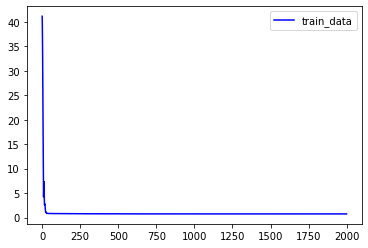

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(loss_data_train)),loss_data_train,c="blue",label= "train_data")
plt.legend()
plt.show()

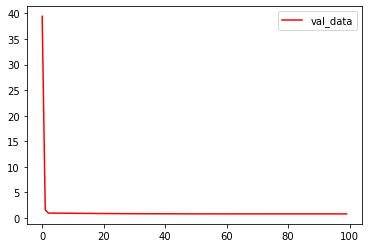

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(loss_data_val)),loss_data_val,c="red",label= "val_data")
plt.legend()
plt.show()

In [41]:
y_val = net(X_val_tensor.unsqueeze(1)) 

In [42]:
y_val = y_val.squeeze().detach().numpy()

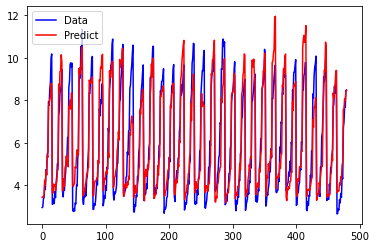

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(Y_val)),Y_val,c="blue",label= "Data")
plt.plot(range(len(y_val)),y_val,c="red",label = "Predict")
plt.legend()
plt.show()

In [44]:
y_val_array = []
for item in y_val:
    y_val_array.append(item)

Y_val_array = []
for item in Y_val:
    Y_val_array.append(float(item))   
    
    
  
m=MSE(Y_val_array,y_val_array)  
r = stats.pearsonr(y_val_array,Y_val_array) 
t=time.strftime("%Y-%m-%d %H:%M:%S",time.localtime())
NN_struct="{0}、{1}、{2}".format(d1,d2,d3)
print (m)
print (r)
print (NN_struct)

path='performance.csv'
csvfile= open(path, 'a', newline='') 
if os.path.getsize(path)!=0:
    writer = csv.writer(csvfile)
    row=[t,freq,NN_struct,str(m),str(r)]  
    writer.writerow(row)
    #writer.writerow(Y_val_array)
    #writer.writerow(y_val_array)
    csvfile.close()  
else:
    writer = csv.writer(csvfile)
    row0 = [u'time', u'frequency（s）', u'structure', u'MSE', u'pearson'] 
    #writer.writerow('\t'.join(row0) + '\n')
    writer.writerow(row0)
    row=[t,freq,NN_struct,str(m),str(r)]  
    writer.writerow(row)
    csvfile.close()    

0.8158695476703729
(0.9349455321497474, 3.007087825475138e-217)
9、8、1
